# Modelo de predicción

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor


1. Leer los datos procesados

In [2]:
df = pd.read_csv('../data/consumption_features.csv')
df.head()

,Passenger_Count,Unit_Cost,haul,Origin_DOH,Origin_JFK,Origin_LHR,Origin_MEX,Origin_NRT,Origin_ZRH,Product_BRD001,Product_CHO050,Product_COF200,Product_CRK075,Product_DRK023,Product_DRK024,Product_HTB110,Product_JCE200,Product_NUT030,Product_SNK001,Percentage_Returned
0,272,0.35,2,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0.327684
1,272,0.80,2,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,0.326531
2,272,0.75,2,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,0.274809
3,272,0.45,2,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.180488
4,272,0.50,2,True,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,0.482234


## Preparación del dataset

1. Preparación de los datos

In [3]:
TARGET_COLUMN = 'Percentage_Returned'
feature_columns = [col for col in df.columns if col != TARGET_COLUMN]

X = df[feature_columns]
y = df[TARGET_COLUMN]

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.20,
    random_state=42
)

print(f"Forma de X_train: {X_train.shape}")
print(f"Forma de X_test: {X_test.shape}")
print(f"Forma de y_train: {y_train.shape}")
print(f"Forma de y_test: {y_test.shape}")

missing_train = X_train.isna().sum()
if missing_train.any():
    print("Columnas con valores faltantes en entrenamiento:")
    print(missing_train[missing_train > 0])
else:
    print("No se detectaron valores faltantes en X_train.")


Forma de X_train: (373, 19)
Forma de X_test: (94, 19)
Forma de y_train: (373,)
Forma de y_test: (94,)
No se detectaron valores faltantes en X_train.


## Modelos y Parámetros

In [4]:
rf_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    (
        "model",
        RandomForestRegressor(
            n_estimators=200,
            random_state=42,
            n_jobs=-1,
            max_features="sqrt"
        ),
    ),
])

rf_pipeline


AttributeError: 'bool' object has no attribute 'all'

AttributeError: 'bool' object has no attribute 'all'

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('model',
                 RandomForestRegressor(max_features='sqrt', n_estimators=200,
                                       n_jobs=-1, random_state=42))])

## Entrenamiento del modelo

In [5]:
print("Entrenando el modelo base de Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("Entrenamiento finalizado.")


Entrenando el modelo base de Random Forest...
Entrenamiento finalizado.


--- Métricas del modelo base ---
MAE: 0.0847
RMSE: 0.1069
R²: -0.3361
Ejemplo de predicciones vs. valores reales:
      actual  predicted     error
0   0.178744   0.274449 -0.095705
1   0.148810   0.411606 -0.262796
2   0.211921   0.347574 -0.135654
3   0.392000   0.395892 -0.003892
4   0.387597   0.215357  0.172240
5   0.151515   0.346213 -0.194698
6   0.203540   0.251567 -0.048028
7   0.194631   0.401722 -0.207091
8   0.402597   0.301920  0.100678
9   0.326087   0.391728 -0.065641
10  0.349776   0.388161 -0.038385
11  0.477612   0.300010  0.177602
12  0.335227   0.344590 -0.009363
13  0.428571   0.453069 -0.024497
14  0.228261   0.319572 -0.091311


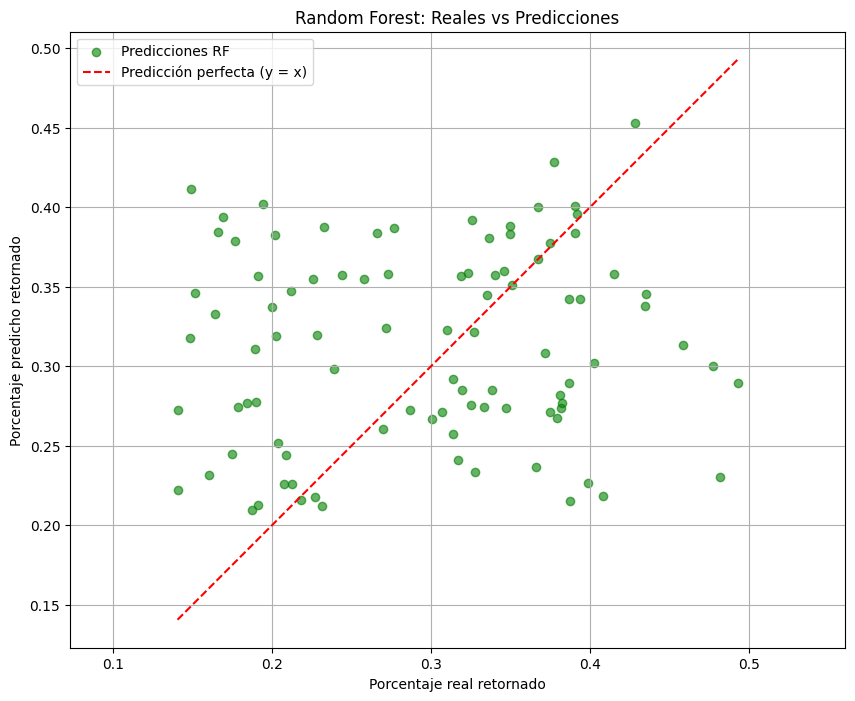

In [6]:
y_pred = rf_pipeline.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("--- Métricas del modelo base ---")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

comparison_df = pd.DataFrame({
    'actual': y_test.reset_index(drop=True),
    'predicted': y_pred,
})
comparison_df['error'] = comparison_df['actual'] - comparison_df['predicted']
print("Ejemplo de predicciones vs. valores reales:")
print(comparison_df.head(15))

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='green', label='Predicciones RF')
lims = [
    min(y_test.min(), y_pred.min()),
    max(y_test.max(), y_pred.max()),
]
plt.plot(lims, lims, 'r--', label='Predicción perfecta (y = x)')
plt.xlabel('Porcentaje real retornado')
plt.ylabel('Porcentaje predicho retornado')
plt.title('Random Forest: Reales vs Predicciones')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()


# Recommendations for Improving the Model

This section includes changes to improve the model's performance and reduce error.

In [7]:
print("Evaluando desempeño con validación cruzada (cv=5)...")
cv_scores = cross_validate(
    rf_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring=("neg_mean_absolute_error", "r2"),
    return_train_score=True,
    n_jobs=1,
)

cv_mae = -cv_scores['test_neg_mean_absolute_error']
cv_r2 = cv_scores['test_r2']

print(f"MAE promedio (validación): {cv_mae.mean():.4f} ± {cv_mae.std():.4f}")
print(f"R² promedio (validación): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")


Evaluando desempeño con validación cruzada (cv=5)...
MAE promedio (validación): 0.0838 ± 0.0059
R² promedio (validación): -0.2499 ± 0.0947


In [8]:
param_distributions = {
    'model__n_estimators': [100, 200, 300, 400],
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__max_features': ['sqrt', 'log2', 0.6],
}

rf_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=param_distributions,
    n_iter=20,
    scoring='neg_mean_absolute_error',
    cv=5,
    random_state=42,
    n_jobs=1,
    verbose=2,
)

print("Iniciando búsqueda de hiperparámetros...")
rf_search.fit(X_train, y_train)
print("Mejores parámetros encontrados:")
print(rf_search.best_params_)


Iniciando búsqueda de hiperparámetros...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   0.1s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   0.1s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   0.1s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   0.1s
[CV] END model__max_depth=10, model__max_features=sqrt, model__min_samples_leaf=2, model__min_samples_split=2, model__n_estimators=200; total time=   0.1s
[CV] END model__max_depth=None, model__max_features=0.6, model__min_samples_leaf=1, model__min_samples_split=2, model__n_e

Evaluando el modelo optimizado...
MAE (optimizado): 0.0785
MSE (Optimizado): 0.0086
RMSE (optimizado): 0.0927
R² (optimizado): -0.0044
Top 10 características más importantes:
Passenger_Count    0.307981
Unit_Cost          0.126161
Origin_JFK         0.057875
haul               0.052281
Product_DRK023     0.051056
Origin_NRT         0.041859
Product_COF200     0.039910
Origin_DOH         0.038462
Product_DRK024     0.035344
Product_NUT030     0.032879
dtype: float64


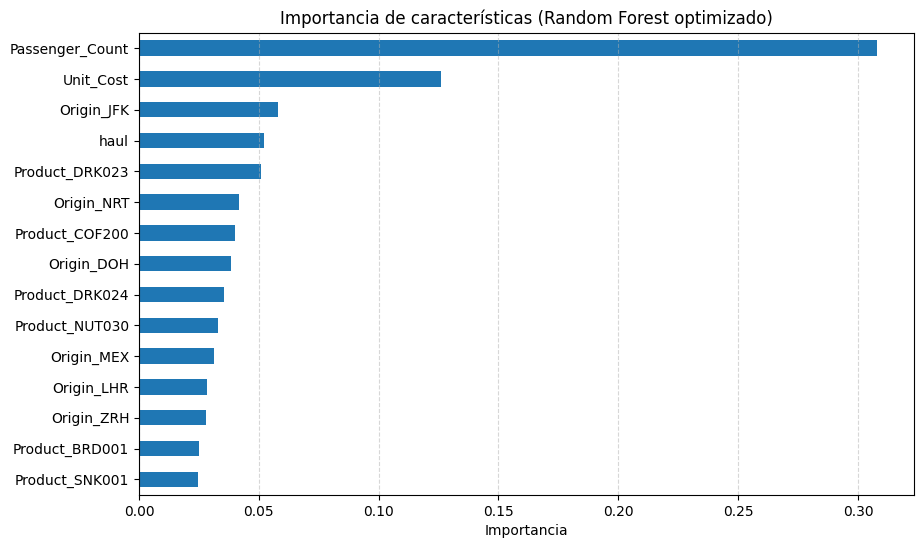

In [10]:
best_model = rf_search.best_estimator_

print("Evaluando el modelo optimizado...")

y_pred_best = best_model.predict(X_test)

tuned_mae = mean_absolute_error(y_test, y_pred_best)
tuned_mse = mean_squared_error(y_test, y_pred_best)
tuned_rmse = np.sqrt(tuned_mse)
tuned_r2 = r2_score(y_test, y_pred_best)

print(f"MAE (optimizado): {tuned_mae:.4f}")
print(f"MSE (Optimizado): {tuned_mse:.4f}")
print(f"RMSE (optimizado): {tuned_rmse:.4f}")
print(f"R² (optimizado): {tuned_r2:.4f}")

# Importancia de características
tree_model = best_model.named_steps['model']
try:
    feature_names = best_model.named_steps['imputer'].get_feature_names_out(X_train.columns)
except AttributeError:
    feature_names = X_train.columns.to_numpy()

feature_importances = pd.Series(tree_model.feature_importances_, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)

print("Top 10 características más importantes:")
print(feature_importances.head(10))

feature_importances.head(15).plot(kind='barh', figsize=(10, 6))
plt.gca().invert_yaxis()
plt.xlabel('Importancia')
plt.title('Importancia de características (Random Forest optimizado)')
plt.grid(True, axis='x', linestyle='--', alpha=0.5)
plt.show()
